In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pathlib
import ffmpeg
import numpy as np
from PIL import Image
import sys
import sys
sys.path.insert(0, "../controller")
import tile_configuration

In [6]:
g = glob.glob("../controller/movie/*/tile_config.0.json")
s = sorted(g, key=lambda x: float(x.split("/")[-2]))
d = pathlib.Path(s[-1])
t = tile_configuration.tile_config_to_tileconfiguration(d.parent)


In [7]:
df = pd.read_json(d, lines=True, orient='records')
#df.index = df["sequence"]
#df.drop("sequence", axis=1, inplace=True)
df["timestamp"] = pd.to_datetime(df['tv_sec'], unit='s') + pd.to_timedelta(df['tv_nsec'], unit='ns')
df.drop("tv_sec", axis=1, inplace=True)
df.drop("tv_nsec", axis=1, inplace=True)

In [8]:

df['timestamp_shift'] = df['timestamp'].shift()
df['timestamp_delta'] = df['timestamp'] - df['timestamp_shift']


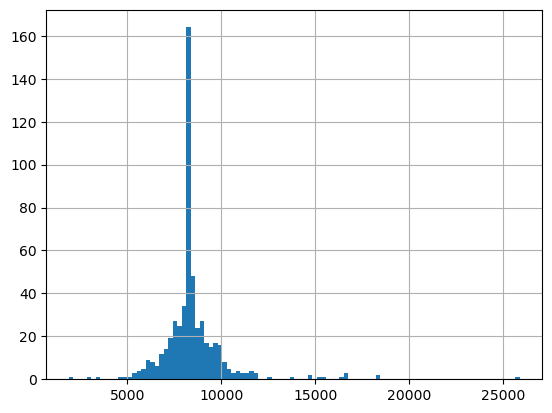

In [10]:
%matplotlib inline
#df.plot(y="timestamp_delta")
df['timestamp_delta'].dt.microseconds.hist(bins=100)
plt.show()

In [31]:
fname = d.parent / "test.0.mkv"

process = (
    ffmpeg.
    input(
        fname
    )
    .output(
        "pipe:", format="rawvideo", pix_fmt="rgb24"
    )  
    .run_async(pipe_stdout=True)
    )

for item in df['sequence'].to_list():
    r= process.stdout.read(1280*720*3)
    n = np.frombuffer(r, np.uint8).reshape(720, 1280, 3)
    i = Image.fromarray(n)
    fname = d.parent / "images" / ("test.%05d.png" % item)
    i.save(fname)
    if len(r) == 0:
        break

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena